In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, KBinsDiscretizer
from sklearn.compose import TransformedTargetRegressor
import pandas as pd
import tensorflow as tf
import numpy as np
import json

#  Import and read the charity_data.csv.
import pandas as pd 

In [2]:
initial_df = pd.read_json("drifting_ll_1.json")
initial_df.head()

,mmsi,timestamp,speed,course,lat,lon,is_fishing
0,12639560807591,2012-01-21 09:01:44,8.2,230.500000,14.865583,-26.853662,-1
1,12639560807591,2012-01-21 09:03:25,7.3,238.399994,14.863870,-26.856800,-1
2,12639560807591,2012-01-21 09:05:34,6.8,238.899994,14.861551,-26.860649,-1
3,12639560807591,2012-01-21 10:54:41,6.9,251.800003,14.822686,-26.865898,-1
4,12639560807591,2012-01-21 10:55:41,6.1,231.100006,14.821825,-26.867579,-1


In [3]:
initial_df['lat'] = initial_df['lat'].astype(int)
initial_df['lon'] = initial_df['lon'].astype(int)
initial_df['speed'] = initial_df['speed'].astype(int)

In [4]:
#mmsi is an identifier (aka the boat name). drop it
# time stamp? 
# what does the course number mean 
# -1=standard 'loitering', other two are more active? 1 0
# round lat and lon to ints for sanity's sake
# process timestamp into year month? 
month_list = []
for i in range(len(initial_df['timestamp'])):
    month_list.append(initial_df['timestamp'][i].month_name())

initial_df["Month"] = month_list
initial_df.head()

,mmsi,timestamp,speed,course,lat,lon,is_fishing,Month
0,12639560807591,2012-01-21 09:01:44,8,230.500000,14,-26,-1,January
1,12639560807591,2012-01-21 09:03:25,7,238.399994,14,-26,-1,January
2,12639560807591,2012-01-21 09:05:34,6,238.899994,14,-26,-1,January
3,12639560807591,2012-01-21 10:54:41,6,251.800003,14,-26,-1,January
4,12639560807591,2012-01-21 10:55:41,6,231.100006,14,-26,-1,January


In [5]:
year_list = []
for i in range(len(initial_df['timestamp'])):
    year_list.append(initial_df['timestamp'][i].year)

initial_df["Year"] = year_list
initial_df.head()

,mmsi,timestamp,speed,course,lat,lon,is_fishing,Month,Year
0,12639560807591,2012-01-21 09:01:44,8,230.500000,14,-26,-1,January,2012
1,12639560807591,2012-01-21 09:03:25,7,238.399994,14,-26,-1,January,2012
2,12639560807591,2012-01-21 09:05:34,6,238.899994,14,-26,-1,January,2012
3,12639560807591,2012-01-21 10:54:41,6,251.800003,14,-26,-1,January,2012
4,12639560807591,2012-01-21 10:55:41,6,231.100006,14,-26,-1,January,2012


In [6]:
processing_df = initial_df.drop(["mmsi","timestamp"], axis=1)
processing_df.head()

,speed,course,lat,lon,is_fishing,Month,Year
0,8,230.500000,14,-26,-1,January,2012
1,7,238.399994,14,-26,-1,January,2012
2,6,238.899994,14,-26,-1,January,2012
3,6,251.800003,14,-26,-1,January,2012
4,6,231.100006,14,-26,-1,January,2012


In [7]:
processing_df['course'].value_counts()

360.000000    426
201.000000     23
22.000000      23
24.000000      21
200.000000     20
             ... 
79.900002       1
326.399994      1
332.799988      1
146.100006      1
272.500000      1
Name: course, Length: 3241, dtype: int64

In [8]:
to_test = pd.get_dummies(processing_df)
X = to_test.drop(['speed'], axis=1)
y = to_test['speed']
X.columns

Index(['course', 'lat', 'lon', 'is_fishing', 'Year', 'Month_April',
       'Month_August', 'Month_December', 'Month_February', 'Month_January',
       'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September'],
      dtype='object')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')
#regressor was used here due to all of the data being numeric. Classifier refuses to process different shaped numeric information 


Training Score: 0.9193469983285205
Testing Score: 0.5517769541350874


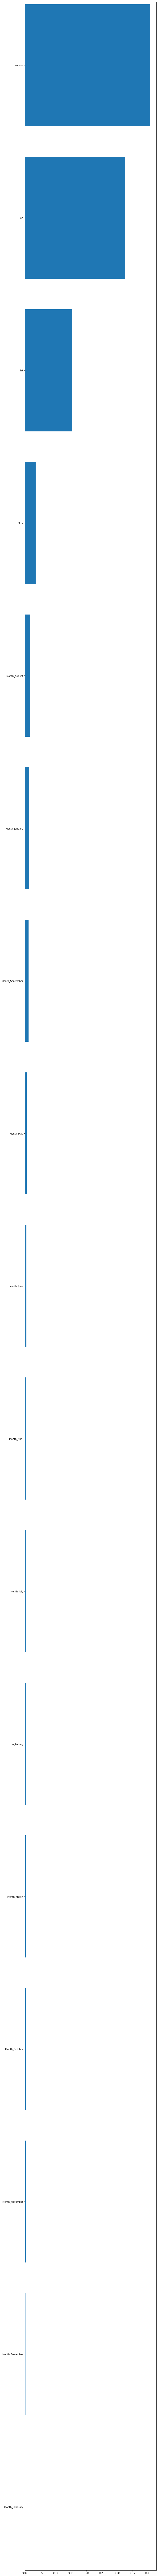

In [11]:
#we can't do predictions with this data but we can do feature importance 
import matplotlib.pyplot as plt
feature_importances = clf.feature_importances_
features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10,200)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [12]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(clf)
sel.fit(X_train_scaled, y_train)

X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

c:\Users\steph\anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [13]:
# the selected dataset works even worse which indicates that even with selected/reduced features; it is quite overfit
clf = RandomForestRegressor().fit(X_selected_train_scaled, y_train)
print(f'Training Score: {clf.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_selected_test_scaled, y_test)}')

Training Score: 0.902801730956478
Testing Score: 0.46947014714245383


In [14]:
#trying other models; the trees are still doing the best but they are overfit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
data = [X_train_scaled, X_test_scaled, y_train, y_test]

def test_model(model, data):
    X_train_scaled, X_test_scaled, y_train, y_test = data
    reg = model.fit(X_train_scaled, y_train)
    print(f'Model: {type(reg).__name__}')
    print(f'Train score: {reg.score(X_train_scaled, y_train)}')
    print(f'Test Score: {reg.score(X_test_scaled, y_test)}\n')
    plt.show()    

test_model(KNeighborsRegressor(), data)
test_model(RandomForestRegressor(), data)
test_model(ExtraTreesRegressor(), data)
test_model(AdaBoostRegressor(), data)
test_model(SVR(C=1.0, epsilon=0.2), data)

Model: KNeighborsRegressor
Train score: 0.6243771307302879
Test Score: 0.4774186373783088

Model: RandomForestRegressor
Train score: 0.919379931190844
Test Score: 0.533906268537574

Model: ExtraTreesRegressor
Train score: 0.9950507537325064
Test Score: 0.3098503848129067

Model: AdaBoostRegressor
Train score: 0.3008082480478893
Test Score: 0.18333565889478975

Model: SVR
Train score: 0.25830522636872644
Test Score: 0.2968887104109743



In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)
df_scaled = StandardScaler().fit_transform(to_test)
speed_pca = pca.fit_transform(df_scaled)

pca.explained_variance_ratio_

array([0.14627018, 0.08323026, 0.0685773 , 0.06567256, 0.06357279,
       0.06190696, 0.06070605, 0.06049018, 0.05919352, 0.05809976,
       0.05715178, 0.05577119, 0.05043769, 0.04524713])

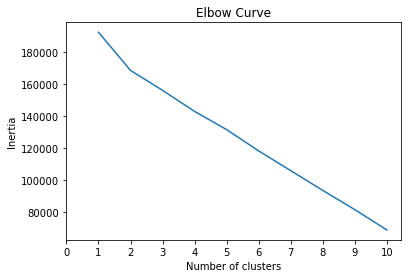

In [16]:
from sklearn.cluster import KMeans
# Finding the best value for k
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(speed_pca)
    inertia.append(km.inertia_)

# Creating the Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(list(range(11)))
plt.title('Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [19]:
speed_pca[0]

array([ 1.70334285,  0.74682016, -1.61725178, -1.52308351,  0.05705425,
        0.11557757, -0.69133479,  0.45344619,  1.31340383, -1.510557  ,
       -2.15983085,  1.45530429,  0.38694817,  2.67413054])

In [21]:
model = KMeans(n_clusters=2, random_state=0)

# Fit the model
model.fit(speed_pca)

# Predict clusters
predictions = model.predict(speed_pca)



In [27]:
speed_df = pd.DataFrame(speed_pca)
speed_df['Predictions'] = predictions
speed_df.head()
#from 18 dimensions to 14 dimensions

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Predictions
0,1.703343,0.746820,-1.617252,-1.523084,0.057054,0.115578,-0.691335,0.453446,1.313404,-1.510557,-2.159831,1.455304,0.386948,2.674131,1
1,1.656566,0.736037,-1.775711,-1.567465,0.012410,0.119346,-0.702440,0.469911,1.302144,-1.509907,-2.157752,1.336628,0.415798,2.562954,1
2,1.613239,0.729462,-1.903625,-1.628935,-0.022958,0.122694,-0.711908,0.488573,1.291623,-1.509776,-2.153435,1.262723,0.440270,2.416990,1
3,1.607225,0.722128,-1.956874,-1.599146,-0.039130,0.123425,-0.714762,0.484744,1.290337,-1.508871,-2.157338,1.184675,0.447901,2.477633,1
4,1.616875,0.733897,-1.871428,-1.646947,-0.013179,0.122252,-0.710183,0.490889,1.292401,-1.510324,-2.151075,1.309915,0.435656,2.380322,1


In [31]:
speed_df[0]

0        1.703343
1        1.656566
2        1.613239
3        1.607225
4        1.616875
           ...   
11395    0.133159
11396    0.088480
11397    0.176671
11398    0.138564
11399   -0.247984
Name: 0, Length: 11400, dtype: float64

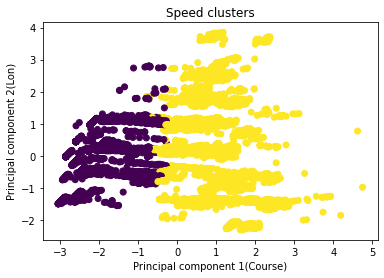

In [35]:
#possible visual; the labels are probably guesses since they're the most impactful and the dataframe is structured to putting the first calculation first
# could do tsne to further reduce dimensions to 2 
plt.scatter(x=speed_df[0], y=speed_df[1], c=speed_df['Predictions'])
plt.xlabel('Principal component 1(Course)')
plt.ylabel('Principal component 2(Lon)')
plt.title('Speed clusters')
plt.show()

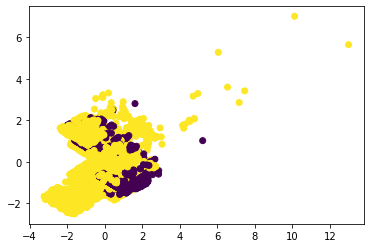

In [36]:
#there is high variance between each image
plt.scatter(x=speed_df[2], y=speed_df[3], c=speed_df['Predictions'])
plt.show()